## Approach

* This is a simplied version of YOLO. The input image is 512x512. YOLO was intended to train on images which all contained at least one object, most multiple objects. The architecture and loss functions have been adapted for this case, where not every image contains an object and there are at most 4 ROIs per image. 
* Since the maximum number of ROIs in each image is 4 we decided to use a 2x2 grid to simplify the network. In the case where multiple ROIs occur in the same cell we combine the ROIs into a single ROI by expanding the box to include both. Each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
    * We have removed the entire classification section, using the confidence to indicate whether there is an ROI in the cell instead.
* A sigmoid is applied to the output of the network to result in values between 0 and 1    
* The x and y coordinates are offsets from the upper left corner of each cell, the w and h are percentage of the total width.
* The loss function is based on YOLO with some differences:
    * The weights of the components have been updated
    * The classification loss has been removed.
    * The "objectness" loss of YOLO tries to make the confidence match the actual IOU. Since our model only outputs one box per cell, this doesn't really make any sense and ends up driving the confidence down to the IOU. We replace this by an IOU loss which subtracts the IOU for that cell from 1.

## Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* There are two dilated convolutions at the end of the network to provide context.
* The dilated convolutions are followed by two strided convolutions which downsize to 2x2.
* Finally there are a series of 1x1 convolutions which output a 2x2x5 tensor.
* We are using an Adam optimizer with gradient clipping to avoid exploding gradients, which had been a problem.

## Predictions
* To generate our predictions we loop through each cell of the output
* We unnormalize the output to get the actual values
* If the confidence is greater than 0.5 and the box has width and height we append it to the list of candidates.
* We apply non-max suppression to remove duplicates.
* The remaining boxes are concatenated onto the output string.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location.
* v8 - using custom loss function based on YOLO loss. Set default height and width to 1 px because 0 sent the gradients to -inf which screwed everything up.
* v10 - using 2x2 grid as output
* v12 - changing layout of model slightly - replaced final pools with convs with strides; reduced number of params; ensure that there is at least one positive image per batch.
* v13 - tweaking architecture slightly.
* v14 - going to 5x5 grid
* v15 - downsizing with average and max pool followed by 1x1 convolutions
* v15.2 - fixed an error where a layer of the network was being bypassed, removed some layers to prevent overfitting, training on labels with jittered ROIs
* v18 - separating fc branches for confidence and boxes, might work better?
* v19 - removing double pools and just using a simple max pool
* v20 - adding more layers to network, simplifying metrics and loss function
* v21 - trying 7x7 grid, removing one downsampling layer to keep input size reasonable

In [ ]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip install -q pydicom 
!pip install -q imgaug 
!pip install -q kaggle
!pip install -q tqdm 

In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
from skimage.filters import gaussian
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
        'mimeType': 'application/octet-stream',
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [2]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]#.astype("int")

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

# sigmoid in numpy, with limit to avoid nans                             
def sigmoid(x):
    # to avoid NaNs set a lower floor on x values
    y = np.maximum(x, -700)
    y = np.minimum(y, 700)
    return 1 / (1 + np.exp(-y))    

# adjust contrast of image
def change_contrast(img, contrast_factor):
    mean = np.mean(img)
    img = (img - mean) * contrast_factor + mean
    return img

def get_intersect(box1, box2):
    # unpack each box
    x1, y1, w1, h1, c1 = box1
    x2, y2, w2, h2, x2 = box2
    
    # get the far corners
    x1_f = x1 + w1
    y1_f = y1 + h1
    x2_f = x2 + w2
    y2_f = y2 + h2
    
    # get corners of intersection
    x1_i = np.maximum(x1, x2)
    y1_i = np.maximum(y1, y2)
    x2_i = np.minimum(x1_f, x2_f)
    y2_i = np.minimum(y1_f, y2_f)
    
    w_i = x2_i - x1_i
    h_i = y2_i - y1_i
    
    w_i = np.maximum(w_i, 0)
    h_i = np.maximum(h_i, 0)

    intersect_area = w_i * h_i
    
    return intersect_area  
  
# helper function to calculate IoU
def calculate_iou(box1, box2):
    x11, y11, w1, h1 = box1[:4]
    x21, y21, w2, h2 = box2[:4]
    assert w1 * h1 > 0
    assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union  

# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred):
    label_array = np.zeros((1024, 1024))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for truth in y_true:
        x,y,w,h = truth[:4].astype(int)  
        label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((1024, 1024))
    for pred in y_pred:
        x,y,w,h = pred[:4].astype(int)

        # update the pixels
        pred_array[y:y+h, x:x+w] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou      
      
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None
    elif (len(boxes_true) == 0) and (len(boxes_pred) != 0):
        return 0
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = calculate_iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)      

# given the label or predictions, return a list containing the actual coordinates
# for each box
def unnorm_label(label, threshold=0.5):
    grid_size = label.shape[0]
    cell_size = 1024 / grid_size
    
    boxes = []
    # loop through the cells of our label
    for i in range(grid_size):
        for j in range(grid_size):
            # if we have a box in a cell
            if label[i,j,0] > threshold:
                # unpack the data
                c, x, y, w, h = label[i, j]
                
                # unnormalize the data
                w, h = int(w*1024), int(h*1024)
                x = unnorm(x, j, cell_size)
                y = unnorm(y, i, cell_size)
                
                # get the corners
                x = int(x - (w / 2))
                y = int(y - (h / 2))
                
                # it's possible the corner is in another cell, if so catch the error
                x = np.maximum(x, 0)
                y = np.maximum(y, 0)
                    
#                 print(x, y, w, h, "box:", i, j)
                boxes.append([x, y, w, h, c])
    
    return boxes

In [3]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [ ]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
if not os.path.exists("./stage_1_detailed_class_info.csv.zip"):
    !kaggle competitions download -c rsna-pneumonia-detection-challenge

In [ ]:
# unzipping takes a few minutes
if not os.path.exists("./stage_1_train_labels.csv"):
    print("Unzipping...")
    !unzip -q -o stage_1_test_images.zip -d stage_1_test_images
    !unzip -q -o stage_1_train_images.zip -d stage_1_train_images
    !unzip -q -o stage_1_train_labels.csv.zip

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [4]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [4]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp gs://{bucket_name}/yolo_labels_centered_7x7_10a.p .yolo_labels_centered_7x7_10a.p

Updated property [core/project].
Copying gs://pneumonia/yolo_labels_centered_5x5_10a.p...
- [1 files][ 26.4 MiB/ 26.4 MiB]                                                
Operation completed over 1 objects/26.4 MiB.                                     


In [5]:
with open('yolo_labels_centered_7x7_10a.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [6]:
random.seed(1702)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.15)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 21832
n valid samples 3852


In [7]:
positive_images = []

for filename in pneumonia_locations:
    label = pneumonia_locations[filename][...,0]
    if np.max(label) > 1e-6:
        if filename + ".dcm" in train_filenames:
            positive_images.append(filename + ".dcm")

 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [8]:
BATCH_SIZE = 6
IMAGE_SIZE = 448
GRID_SIZE = 7
CELL_SIZE = 1024 / GRID_SIZE
CHECKPOINT_PATH = "yolo21_1_448.h5"

In [9]:
!gsutil cp gs://{bucket_name}/{CHECKPOINT_PATH} ./{CHECKPOINT_PATH}

Copying gs://pneumonia/yolo21_1_448.h5...
\ [1 files][ 77.0 MiB/ 77.0 MiB]    3.8 MiB/s                                   
Operation completed over 1 objects/77.0 MiB.                                     


In [9]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def augment_imgs(self, img, confs, boxes):
        # flip the image half the time
        if random.random() > 0.5:
            img = np.fliplr(img)
            
            # update our x coords
            mask = (confs != 0)
            
            # flip
            boxes[mask, 0] = (1 - boxes[mask,0])
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=1)   
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=1)            
        
        # slight shape skew
        if random.random() > 0.5:
            x_scale = np.random.uniform(low=0.96, high=1.04, size=None)
            y_scale = np.random.uniform(low=0.96, high=1.04, size=None)
            
            # resize the image
            img = resize(img, (int(1024 * y_scale), int(1024 * x_scale)), mode='reflect')
            
            # resize the boxes
            boxes[...,2] = (boxes[...,2] * x_scale)
            boxes[...,3] = (boxes[...,3] * y_scale)
         
        # adjust contrast or contrast
        if random.random() > 0.5:  
            if random.random() > 0.5:  
                factor = np.random.uniform(low=0.85, high=1.15)
                img = img * factor
            else:
                # generate a random contrast adjustment
                contrast_factor = np.random.normal(loc=1.0, scale=0.10)

                # put some limits on the contrast
                contrast_factor = np.minimum(contrast_factor, 1.25)
                contrast_factor = np.maximum(contrast_factor, 0.75)

                # adjust the image
                img = change_contrast(img, contrast_factor)

        # gaussian blur
        if random.random() > 0.5:
            sigma = np.random.uniform(low=0, high=1.25)
            img = gaussian(img, sigma=sigma)
        
        # random crop or pad
        crop_or_pad = random.random()
        # crop
        if crop_or_pad > 0.66:
            # crop by max of 16 pixels
            h_offset_1 = np.random.randint(low=0, high=20)
            v_offset_1 = np.random.randint(low=0, high=20)
            
            h_offset_2 = 1024 - np.random.randint(low=0, high=20)
            v_offset_2 = 1024 - np.random.randint(low=0, high=20)
            
            # crop the images
            img = img[v_offset_1:v_offset_2,h_offset_1:h_offset_2]
            
            # update the labels - make sure they are positive
            boxes[...,1] = np.maximum((boxes[...,1] - (h_offset_1 / CELL_SIZE)), 0.001)
            boxes[...,2] = np.maximum((boxes[...,2] - (v_offset_1 / CELL_SIZE)), 0.001)
            
        # pad
        elif crop_or_pad > 0.33:
            h_offset_1 = np.random.randint(low=0, high=30)
            v_offset_1 = np.random.randint(low=0, high=30)
            
            h_offset_2 = np.random.randint(low=0, high=30)
            v_offset_2 = np.random.randint(low=0, high=30)
            
            img = np.pad(np.squeeze(img), ((v_offset_1, v_offset_2), (h_offset_1,h_offset_2)), mode="constant", constant_values=0)
            
            # adjust the labels
            right_shift = h_offset_2 - h_offset_1
            down_shift = v_offset_2 - v_offset_1
            
            boxes[...,1] = np.maximum((boxes[...,1] + (right_shift / CELL_SIZE)), 0.001)
            boxes[...,2] = np.maximum((boxes[...,2] + (down_shift / CELL_SIZE)), 0.001)
        
        # small shifts
        if random.random() > 0.5:  
            ## small random shifts
            h_offset = np.random.randint(low=0, high=8)
            v_offset = np.random.randint(low=0, high=8)

            # crop the images
            img = img[v_offset:,h_offset:]
        
        return img, confs, boxes
            
            
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes because they will be flipped separately
        # round the confidences since some are 0.99 or maybe even 1e-6
        confs = np.round(label[:,:,0])
        boxes = label[:,:,1:]
        
        ## augment the data with flips, small shifts and contrast adjustment
        if self.augment:
            img, confs, boxes = self.augment_imgs(img, confs, boxes)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # scale and center the image
        img = (img - np.mean(img)) / np.max(img)
        
        boxes = np.concatenate([confs.reshape((GRID_SIZE,GRID_SIZE,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            bboxes = np.array(bboxes)
            
            # make sure there is at least one positive image in the batch
            pos = np.max(bboxes[:,:,:,0])
            if pos < 1:
                # pick a random positive image
                filename = np.random.choice(positive_images)
                img, label = self.__load__(filename)
                
                # add the positive image to our batch
                imgs[-1] = img
                bboxes[-1] = label
                
            labels = bboxes
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [10]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x_2 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_2])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 448x448x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # downsample to 224x224x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # residual blocks
    for d in range(depth):
        
        x = create_downsample(channels, x)
        channels = channels * 2
        
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    x_2 = x
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 14x14x512
    x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', strides=(1,1), activation=None, name="last_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Dropout(0.15)(x)
    
    # downsample to 7x7 with stride 2
    x = keras.layers.Conv2D(768, (3,3), padding='same', strides=(2,2), activation=None, name="downsample_1", kernel_regularizer=keras.regularizers.l2(l=0.002))(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Dropout(0.15)(x)
    
    # confidence output branch
    c = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.10)(c)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation="sigmoid", name="confidence_output")(c)
    
    # bounding box branch
    b = keras.layers.Conv2D(1568, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.25)(b)
    
    b = keras.layers.Conv2D(1568, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.10)(b)
    
    boxes = keras.layers.Conv2D(4, (1,1), padding='same', activation="sigmoid")(b)
    output = keras.layers.concatenate([confidence, boxes], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=output)
    
    return model

# Train network


In [11]:
# after each epoch run our function to calculate the actual IOU for half of the validation images. 
# I was not able to figure out how to implement this in tensorflow since I don't think we can iterate
# through tensors. So we do it as a callback instead. Hopefully this will approximate the actual IOU score.
class Calc_IOU_CB(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        valid_gen2 = generator(train_dicom_dir, valid_filenames, pneumonia_locations, batch_size=32, image_size=IMAGE_SIZE, shuffle=True, predict=False)
        ious = []
        tps = 0
        fps = 0
        fns = 0
        
        counter = 0
        # catch errors and display them without stopping execution
        try:
            for imgs, labels in valid_gen2:
                preds = self.model.predict(imgs)

                for pred, label in zip(preds, labels):
                    yhat = unnorm_label(pred)
                    y_true = unnorm_label(label)

                    if len(yhat) or len(y_true):
                        iou = calc_iou_better(y_true, yhat)
                        ious.append(iou)

                # calculate the precision and recall
                tp, fp, fn = calc_tps(labels, preds)

                tps += tp
                fps += fp
                fns += fn

                counter += 32

                # only evaluate half of val set each epoch to speed up training
                if counter > len(valid_filenames) / 2:
                    break

            prec = tps / (tps + fps)
            recall = tps / (tps + fns)
            f1_score = 2 * (prec * recall) / (prec + recall)
            print("Epoch", epoch, ": Mean IOU:", np.mean(ious), "Precision:", prec, "Recall:", recall, "F1:", f1_score)
        
        except Exception as e: 
            print(e)
        
        if epoch % 2 == 0:
          !gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/
        
        return
      
# count the true pos, false pos and false negatives so we can calculate precision and recall
def calc_tps(y_true, y_pred):
    true_confs = np.round(y_true[...,0])
    pred_confs = np.round(y_pred[...,0])
    
    tps = np.sum((pred_confs == 1) & (true_confs == 1))
    fps = np.sum((pred_confs == 1) & (true_confs != 1))
    fns = np.sum((pred_confs != 1) & (true_confs == 1))
    
    return tps, fps, fns      

In [12]:
## LOSS FUNCTIONS AND METRICS
GRID_SIZE = 7
CELL_SIZE = 1024 / GRID_SIZE

# calculate f1 score with smoothing to avoid NaNs
def f1_score(y_true, y_pred):
    # apply sigmoid and round our labels
    y_pred = tf.round(y_pred[...,0])
    y_true = tf.round(y_true[...,0])

    # true positives are both pred and truth == 1
    tps = tf.reduce_sum(y_pred * y_true) + 1
    # false positives are truth == 0 and pred == 1
    not_y_true = tf.cast(tf.equal(y_true, 0), dtype=tf.float32)
    fps = tf.reduce_sum(y_pred * not_y_true)
    # false negatives is truth == 1 and pred == 0
    not_y_pred = tf.cast(tf.equal(y_pred, 0), dtype=tf.float32)
    fns = tf.reduce_sum(y_true * not_y_pred)

    precision = tps / (tps + fps)
    recall = tps / (tps + fns)

    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

def binary_accuracy(y_true, y_pred):
    # apply sigmoid to our predictions and round to 0 or 1
    y_pred = tf.round(y_pred)
    y_true = tf.round(y_true)
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true[...,0], y_pred[...,0]), dtype=tf.float32))
    return acc

def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # make sure the truth is an int
    true_boxes = tf.round(true_boxes)
    
    # convert the sigmoid output to center coordinates
    x11 = x11 * CELL_SIZE
    x21 = x21 * CELL_SIZE
    y11 = y11 * CELL_SIZE
    y21 = y21 * CELL_SIZE
    
    # get the actual height and width numbers
    w1 = w1 * 1024
    w2 = w2 * 1024
    h1 = h1 * 1024
    h2 = h2 * 1024
    
    # only count the cell is there is actually an ROI here or if one is predicted
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # get the far corners of the boxes
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1) * (yI2 - yI1)

    # get the area of each box
    bboxes1_area = (w1) * (h1)
    bboxes2_area = (w2) * (h2)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area
    
    iou = tf.maximum(inter_area/(union + 1e-6), 0)
    
    # apply the mask
    iou = iou * tf.cast(mask, dtype=tf.float32)
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(iou)

def overlap_iou2(y_true, y_pred):
    """
    Args:
        y_true and y_pred - arrays of boxes containing center points, h and w of boxes
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Average IOU over boxes
    """
    OVERLAP = 0.3
    
    # apply the sigmoid
#     y_pred = sigmoid(y_pred)
    
    ious = []
    
    # loop over both sets of boxes
    for truth, pred in zip(y_true, y_pred):
        # get true area
        true_area = 0
        true_boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = truth[i,j,:]
                # if we have an ROI
                if c == 1:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    true_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    true_boxes.append([x, y, x+w, y+h])
                    
        pred_area = 0
        pred_boxes = []
        # get the predicted area
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = pred[i,j,:]
                # if we have an ROI
                if c > 0.5:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    pred_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    pred_boxes.append([x, y, x+w, y+h])
            
        intersect_area = 0
        
        # non-max suppression?
        pred_boxes = non_max_suppression_fast(np.array(pred_boxes), OVERLAP)
        
        # get the intersection
        for pred_box in pred_boxes:
            x1_p, y1_p, x2_p, y2_p = pred_box
            
            for true_box in true_boxes:
                x1_t, y1_t, x2_t, y2_t = true_box
                
                # if the boxes overlap at all
                if (x1_p >= x1_t and y1_p >= y1_t) or (x1_p <= x1_t and y1_p <= y1_t):
                    # get the intersection corners
                    x1_i = np.maximum(x1_p, x1_t)
                    y1_i = np.maximum(y1_p, y1_t)
                    x2_i = np.minimum(x2_p, x2_t)
                    y2_i = np.minimum(y2_p, y2_t)
                    
                    # get area of intersect
                    i_w, i_h = x2_i - x1_i, y2_i - y1_i

                    # trap for negative numbers
                    i_w = np.maximum(i_w, 0)
                    i_h = np.maximum(i_h, 0)

                    intersection = i_w * i_h
                    intersect_area += intersection

        union = true_area + pred_area - intersect_area
        
        iou = intersect_area / (union + 1e-16)
        
        # only count the IOU if there are truths or predictions
        if len(true_boxes) or len(pred_boxes):
            ious.append(iou)
    
    iou_area = np.mean(ious)
    return iou_area
                    
def loss_fn(y_true, y_pred):
    # get the iou loss
#     iou_loss = iou_loss_fn(y_true, y_pred)
    
    # get the xe loss
    xe_loss = binary_cross_entropy(y_true, y_pred)
    
    # get the box loss
    box_loss = adj_mse(y_true, y_pred)
    
    # add the losses and return them
    return (1.0 * xe_loss) + (box_loss * 5.0) #+ (iou_loss * 0.25)

def adj_mse(y_true, y_pred):    
    # square the error
#     xy_square_error = tf.square(y_true[...,1:3] - y_pred[...,1:3])
#     wh_square_error = tf.square(tf.sqrt(y_true[...,3:]) - tf.sqrt(y_pred[...,3:]))
#     square_error = xy_square_error + wh_square_error
    square_error = tf.square(y_true[...,1:] - y_pred[...,1:])
    sse = tf.reduce_sum(square_error, axis=[3])
    
    # apply the mask so we only count the loss from cells with actual ROIs
    mask = y_true[...,0]
    
    sse = tf.multiply(sse, mask)
    
    loss = tf.reduce_sum(sse)            
            
    return loss  
  
# use weight of 0.5 for negative cells, 19 for positive ones
def binary_cross_entropy(y_true, y_pred):
    conf_true = tf.round(y_true[...,0])
    conf_pred = y_pred[...,0]
    
    weight = 3.0
    weights = tf.multiply(conf_true, weight) + 0.5
    
    xe = tf.multiply(tf.square(conf_true - conf_pred), weights)
    
    return tf.reduce_sum(xe)

def objectness_loss_fn(y_true, y_pred):
    
    # pred box conf
    pred_box_conf = y_pred[...,0]
    
    # separate the x, y from the w, h
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    true_box_conf = iou_scores * y_true[..., 0]
    
    conf_mask  = tf.zeros_like(iou_scores)
    conf_mask = conf_mask + tf.cast((iou_scores < 0.6), dtype=tf.float32) * (1 - y_true[...,0])
    conf_mask = conf_mask + y_true[..., 0] * 5.0
    
    nb_conf_box  = tf.reduce_sum(tf.cast((conf_mask > 0.0), dtype=tf.float32)) 
    
    loss_conf  =  tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    
    return tf.reduce_sum(loss_conf)

def iou_loss_fn(y_true, y_pred):
    
    # separate the x, y from the w, h and unnormalize them
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # get the area of the boxes
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    # calculate the IOU
    union_areas = pred_areas + true_areas - intersect_areas
    # multiple the IOU by the confidence so we have a more useful loss function
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16) * y_pred[...,0]
    
    # only use the IOU from boxes which actually have ROIs
    mask = y_true[...,0] * 2.0
    
    # subtract IOU from 1 and apply the mask
    use_iou = (1 - iou_scores)
    use_iou = tf.multiply(use_iou, mask)
    
    return tf.reduce_sum(use_iou)

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.006
    epochs_drop = 15
    drop = 0.75
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate
  
catch_nan = tf.keras.callbacks.TerminateOnNaN()  

In [13]:
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, clipnorm=1.0, clipvalue=0.5)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[binary_accuracy, adj_mse, binary_cross_entropy, overlap_iou, f1_score])

model.load_weights(CHECKPOINT_PATH)

use_tpu = False
# if we are using the tpu copy the keras model to a new var and assign the tpu model to model
if use_tpu:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    original_model = model
    
    # create network and compiler
    model = tf.contrib.tpu.keras_to_tpu_model(
        original_model, strategy = tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
    
learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
calc_iou = Calc_IOU_CB()

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=4, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 24) 216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 24) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 224, 224, 24) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
model.load_weights(CHECKPOINT_PATH)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=10, shuffle=True, verbose=1, initial_epoch=6)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=20, shuffle=True, verbose=1, initial_epoch=10)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=30, shuffle=True, verbose=1, initial_epoch=20)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=35, shuffle=True, verbose=1, initial_epoch=29)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=40, shuffle=True, verbose=1, initial_epoch=35)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=50, shuffle=True, verbose=1, initial_epoch=40)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=60, shuffle=True, verbose=1, initial_epoch=50, max_queue_size=100, use_multiprocessing=False)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=75, shuffle=True, verbose=1, initial_epoch=67, max_queue_size=20, use_multiprocessing=False)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=75, shuffle=True, verbose=1, initial_epoch=67, max_queue_size=20, use_multiprocessing=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["f1_score"], label="Train F1")
plt.plot(history.epoch, history.history["val_f1_score"], label="Valid F1")
plt.legend()

plt.show()

## Sample Predictions

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


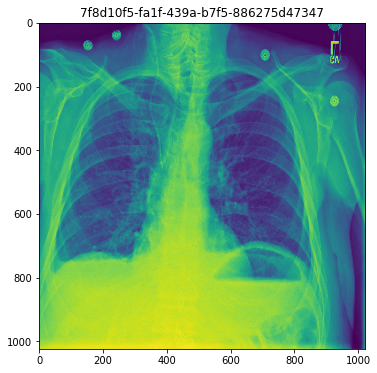

Truth: 2 4 601 251 124 155
False Negative: 2 4 conf: 0.075128846
IOU post-nms: 0.0
IOU: 0.0
Map IOU: 0.0


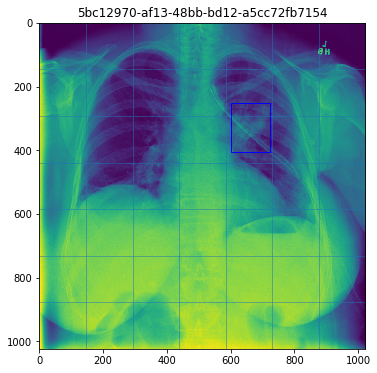

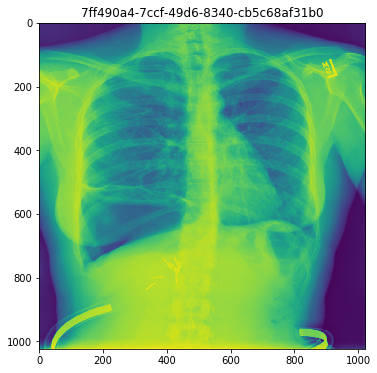

Pred: 1 4 conf: 0.9197586 588 174 196 201
IOU post-nms: 0.0
IOU: 0.0
Map IOU: 0


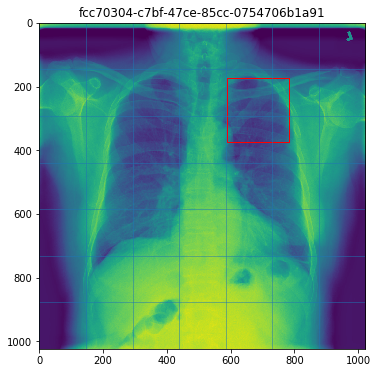

Truth: 2 3 439 335 272 186
Truth: 2 4 439 335 326 186
Truth: 3 1 150 401 237 348
Truth: 3 2 218 401 168 348
Truth: 3 3 439 336 272 434
Truth: 3 4 439 336 326 434
Truth: 4 1 150 401 237 459
Truth: 4 2 218 401 168 459
Truth: 4 3 439 420 272 350
Truth: 4 4 439 420 326 350
Truth: 5 1 150 622 237 238
Truth: 5 2 218 622 168 238
False Negative: 2 3 conf: 0.00016442673
Pred: 2 4 conf: 0.8698631 551 287 192 272
False Negative: 3 1 conf: 0.005760634
False Negative: 3 2 conf: 0.0002307387
False Negative: 3 3 conf: 0.00062455214
Pred: 3 4 conf: 0.88821083 539 330 181 315
False Negative: 4 1 conf: 0.004482593
False Negative: 4 2 conf: 0.00057998335
False Negative: 4 3 conf: 0.0042024516
False Negative: 4 4 conf: 0.07576855
False Negative: 5 1 conf: 0.0065035485
False Negative: 5 2 conf: 0.00066734024
IOU post-nms: 0.22310316582945747
IOU: 0.22310316582945747
Map IOU: 0.010416666666666666


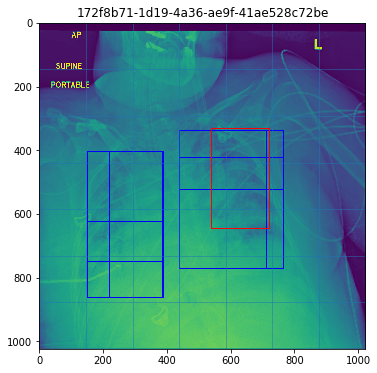

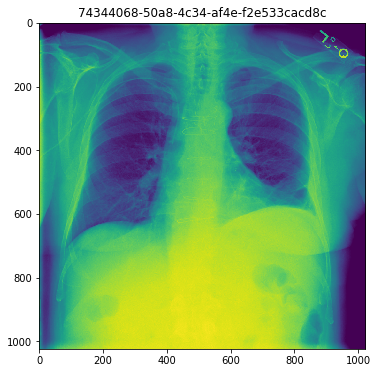

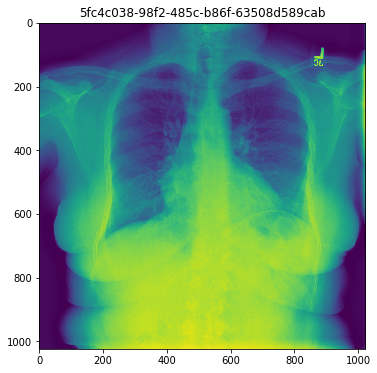

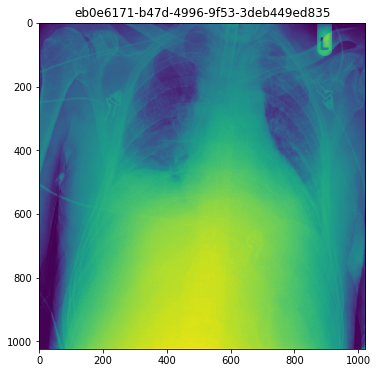

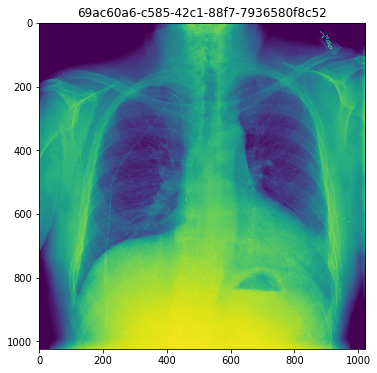

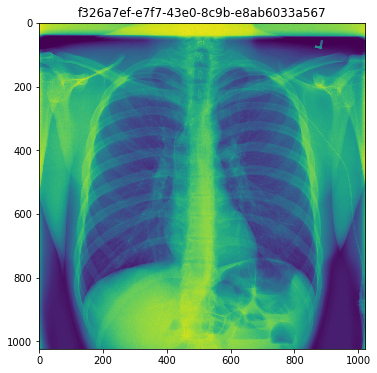

Truth: 2 5 669 296 154 274
Truth: 3 5 669 304 154 274
False Negative: 2 5 conf: 0.042273037
Pred: 3 2 conf: 0.78080416 278 378 176 199
False Negative: 3 5 conf: 0.05482154
IOU post-nms: 0.0
IOU: 0.0
Map IOU: 0.0


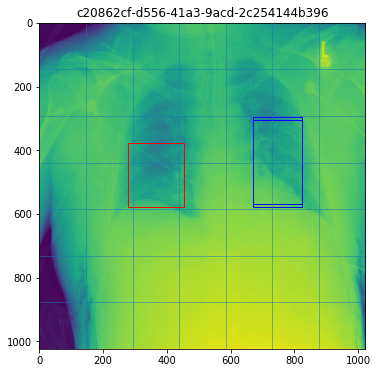

Pred: 1 2 conf: 0.7816102 277 144 181 263
Pred: 2 2 conf: 0.9846523 267 200 195 406
Pred: 3 2 conf: 0.9845221 277 287 199 427
IOU post-nms: 0.0
IOU: 0.0
Map IOU: 0


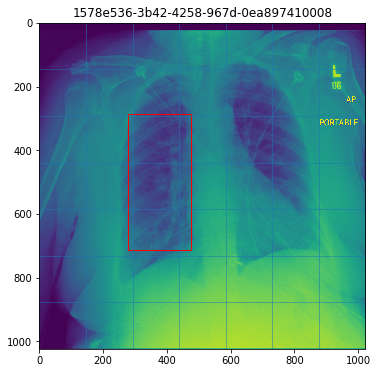

Pred: 3 4 conf: 0.8436404 630 405 168 215
Pred: 3 5 conf: 0.98426765 673 427 176 184
IOU post-nms: 0.0
IOU: 0.0
Map IOU: 0


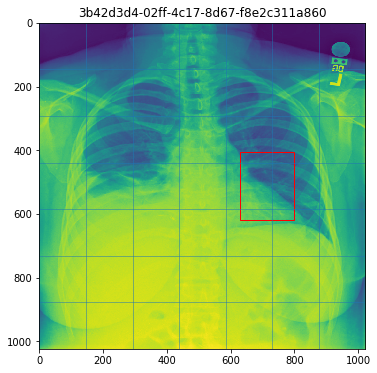

Pred: 3 2 conf: 0.987347 241 438 175 173
IOU post-nms: 0.0
IOU: 0.0
Map IOU: 0


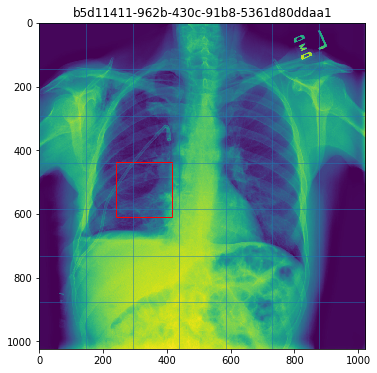

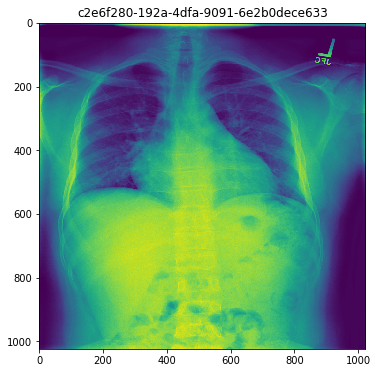

Truth: 2 1 202 213 160 430
Truth: 2 2 203 213 237 430
Truth: 2 4 556 263 211 330
Truth: 3 1 202 213 160 488
Truth: 3 2 203 213 237 488
Truth: 3 4 556 264 211 547
Truth: 4 2 203 488 237 214
Truth: 4 4 556 379 211 432
Pred: 1 1 conf: 0.9993198 185 88 195 380
Pred: 1 2 conf: 0.9997249 200 126 230 304
Pred: 2 1 conf: 0.9997285 193 103 189 570
Pred: 2 2 conf: 0.99989045 199 129 228 539
Pred: 2 4 conf: 0.97931576 588 279 198 281
Pred: 3 1 conf: 0.99431604 192 217 187 465
Pred: 3 2 conf: 0.9966485 207 208 225 481
Pred: 3 4 conf: 0.99998593 574 335 231 444
Pred: 3 5 conf: 0.9987795 648 327 175 477
False Negative: 4 2 conf: 0.008002938
Pred: 4 4 conf: 0.9997515 576 387 225 424
Pred: 4 5 conf: 0.9976094 648 351 185 512
IOU post-nms: 0.59257306472538
IOU: 0.59257306472538
Map IOU: 0.11111111111111113


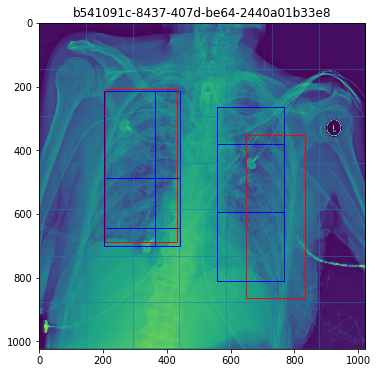

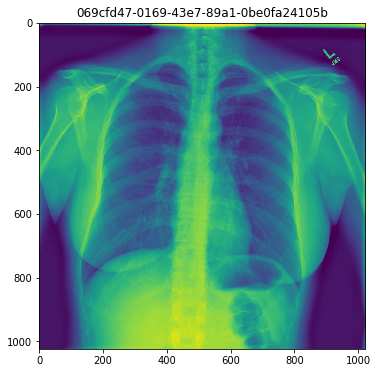

Truth: 2 1 166 129 232 598
Truth: 2 2 166 129 306 598
Truth: 2 4 566 142 290 572
Truth: 2 5 626 142 230 572
Truth: 3 1 166 130 232 685
Truth: 3 2 166 130 306 685
Truth: 3 4 566 143 290 769
Truth: 3 5 626 143 230 769
Truth: 4 1 166 375 232 440
Truth: 4 2 166 375 306 440
Truth: 4 4 566 278 290 634
Truth: 4 5 626 278 230 634
Pred: 1 2 conf: 0.8469559 237 158 196 236
Pred: 1 4 conf: 0.9703193 597 149 208 256
False Negative: 2 1 conf: 0.5254014
Pred: 2 2 conf: 0.9874814 223 207 208 415
Pred: 2 4 conf: 0.9997712 592 205 227 416
Pred: 2 5 conf: 0.9986541 648 230 203 381
False Negative: 3 1 conf: 0.6744432
Pred: 3 2 conf: 0.97756064 219 234 208 480
Pred: 3 4 conf: 0.9998802 601 233 219 440
Pred: 3 5 conf: 0.9991418 646 228 201 460
False Negative: 4 1 conf: 0.050698757
False Negative: 4 2 conf: 0.094598584
False Negative: 4 4 conf: 0.018432658
False Negative: 4 5 conf: 0.18345457
IOU post-nms: 0.44388942236564694
IOU: 0.44388942236564694
Map IOU: 0.11217948717948717


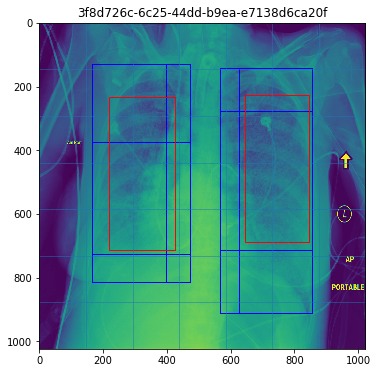

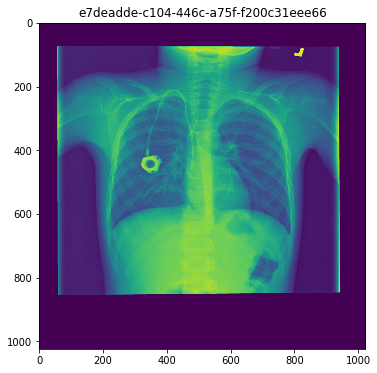

Truth: 2 1 177 307 210 234
Truth: 2 2 178 307 265 234
Truth: 2 4 614 335 214 186
Truth: 2 5 614 335 245 186
Truth: 3 1 177 355 210 186
Truth: 3 2 178 355 265 186
Truth: 3 4 607 335 245 308
Truth: 3 5 614 335 245 308
Pred: 1 1 conf: 0.85158145 185 148 183 251
Pred: 2 1 conf: 0.98991466 184 230 185 323
Pred: 2 2 conf: 0.9581827 221 239 180 243
Pred: 2 4 conf: 0.9586622 632 253 172 279
Pred: 2 5 conf: 0.9802408 666 281 182 225
False Negative: 3 1 conf: 0.6877375
False Negative: 3 2 conf: 0.06603748
False Negative: 3 4 conf: 0.19018714
False Negative: 3 5 conf: 0.40278503
IOU post-nms: 0.45282199625384867
IOU: 0.45282199625384867
Map IOU: 0.1527777777777778


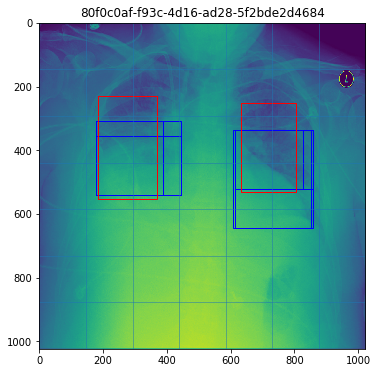

Overall Mean IOU: 0.1712387649174333
Overall Map IOU: 0.038648504273504275


In [14]:
THRESHOLD = 0.75
OVERLAP = 0.3
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=20, replace=False)
# samples = problem_names

coords = np.arange(0, 1024, CELL_SIZE)
overall_ious = []
map_ious = []

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    
    # initialize our lists
    ious = []
    truths = []
    boxes = []
    
    # draw the truth boxes
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename].copy()
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0.5:
                    x, y, w, h = pixel_data[1:]
                    
                    # unnormalize the data
                    w = w * 1024
                    h = h * 1024
                    
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    locs[i,j,:] = [1, x, y, w, h]
                    print("Truth:", i, j, x, y, w, h)
                    truths.append([x, y, w, h])
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
                    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    conf = np.squeeze(yhat)[:,:,0]
    bboxes = np.squeeze(yhat)[:,:,1:]    
    pred_boxes = np.zeros_like(bboxes)
  
    # print the confidences for our true boxes, if any
    mask = (locs[...,0] > 0.5)
    
    # loop through our predictions
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            conf_ = conf[i,j]
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                
                # unnormalize the data
                w = w * 1024
                h = h * 1024

                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)
                
                # convert to upper left corner from center
                x = np.maximum(x - (w // 2), 0)
                y = np.maximum(y - (h // 2), 0)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                pred_boxes[i,j,:] = [x, y, w, h]
                
                print("Pred:", i, j, "conf:", conf_, x, y, w, h)
                
                # if the boxes have width and height add them to our list
                if w > 30 and h > 30:
                    boxes.append([x,y,w,h, conf_])
            elif mask[i,j]:
                print("False Negative:", i, j, "conf:", conf_)
              
    ## if we have ground truths OR predictions calculate the IOUs:
    if len(boxes) or len(truths):
        # do non-max suppression of our boxes
        nms_boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)

        # only count the IOU if there are either ground truths or predictions
        if len(nms_boxes) or len(truths):
            iou = calc_iou_better(np.array(truths), np.array(nms_boxes))
            print("IOU post-nms:", iou)
            overall_ious.append(iou)

        # plot our boxes
        for box in nms_boxes:
            x,y,w,h,c = box
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        if len(nms_boxes):
            scores = nms_boxes[...,4]
        else:
            scores = np.array([])

        map_iou_score = map_iou(np.array(truths), np.array(nms_boxes), scores)

        if map_iou_score is not None:
            map_ious.append(map_iou_score)

        for item in coords:
            plt.axvline(item, linewidth=0.5)
            plt.axhline(item, linewidth=0.5)

        print("IOU:", iou)
        print("Map IOU:", map_iou_score)
    
    plt.title(filename)
    plt.show()
    
print("Overall Mean IOU:", np.mean(overall_ious))    
print("Overall Map IOU:", np.mean(map_ious))    

In [28]:
def scores_at_threshold(y_true, y_pred, thresholds=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
    prec_scores = []
    rec_scores = []
    iou_scores = []
    accurracy_scores = []
    
    # calculate the scores
    for threshold in thresholds:
        # extract the prediction from the input
        pred_true = (y_pred[...,0] > threshold) * 1.0
        gt_true = np.round(y_true[...,0])
        
        # calculate the prec, rec, accuracy
        accuracy = np.mean(pred_true == gt_true)
        
        tp = np.sum(pred_true * gt_true)
        fp = np.sum(pred_true * (gt_true == 0))
        fn = np.sum(gt_true * (pred_true == 0))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        accuracy_scores.append(accuracy)
        prec_scores.append(precision)
        rec_scores.append(recall)
        
        temp_ious = []
        # calculate the IOU
        for gt_, yhat_ in zip(y_true, y_pred):
            gt_rois = unnorm_labels(gt_, threshold)
            pred_rois = unnorm_labels(yhat, threshold)
            
            iou = calc_iou_better(gt_rois, pred_rois)
            temp_ious.append(iou)
        
        iou_scores.append(np.mean(temp_ious))
        
    return prec_scores, rec_scores, iou_scores, accuracy_scores

In [30]:
for imgs, labels in valid_gen:
    preds = model.predict(img)
    prec, rec, iou, acc = scores_at_threshold(labels, preds)
    
    break

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


ResourceExhaustedError: OOM when allocating tensor with shape[6,24,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: bboxes_output/concat/_1117 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1614_bboxes_output/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d/Conv2D', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/eric/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/eric/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/eric/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/eric/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eric/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/eric/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/eric/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/eric/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/eric/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/eric/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/eric/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/eric/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/eric/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-42c114ed1aa5>", line 1, in <module>
    model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)
  File "<ipython-input-10-a929fbf94245>", line 37, in create_network
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/_impl/keras/engine/base_layer.py", line 239, in __call__
    output = super(Layer, self).__call__(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 714, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/convolutional.py", line 168, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 870, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 522, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 206, in __call__
    name=self.name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 953, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[6,24,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: bboxes_output/concat/_1117 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1614_bboxes_output/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
prec

# Predict test images

In [ ]:
THRESHOLD = 0.75

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=24, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    yhats = model.predict(imgs)
    
    # loop through batch
    for yhat, filename in zip(yhats, filenames):
        predictionString = ""
        boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                conf = yhat[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = yhat[i,j, 1:]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        w = w * 1024
                        h = h * 1024

                        x = unnorm(x, j, CELL_SIZE)
                        y = unnorm(y, i, CELL_SIZE)

                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)
        
            # create the prediction string
            predictionString += str(0.9) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [ ]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_file} -m "YOLOv20.1 480x480 70 epochs"

In [ ]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/